# Geometry Plotting

This notebook provides a tutorial for plotting tidy3d objects.

In [1]:
import matplotlib.pylab as plt
import numpy as np

import sys
sys.path.append('..')
import tidy3d as td

## Simple, 2D plotting

### Geometries

All `td.Geometry` objects such as `td.Box`, `td.Sphere`, `td.Cylinder`, `td.PolySlab` have a `.plot()` method that plots their geometries on a plane specified by axis (0,1,2) and position.

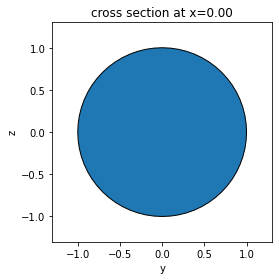

In [2]:
cylinder = td.Cylinder(center=(0,0,0), radius=1, length=2, axis=0)
ax = cylinder.plot(x=0)
plt.show()

### Structures

Plotting `td.Structure` objects, which combine `td.Geometry` with a `td.Medium` works the same way.

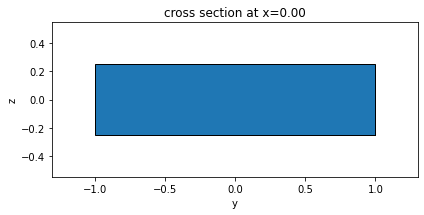

In [3]:
box = td.Structure(
    geometry=td.Box(center=(0.,0.,0), size=(1.,2.,.5)),
    medium=td.Medium(permittivity=2.0)
)

ax = box.plot(x=0)

We can supply `ax` argument to the plot function to plot on a specific matplotlib Axes, for example

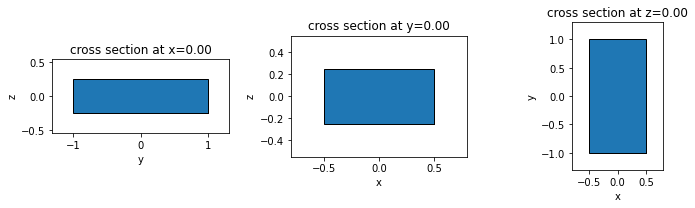

In [4]:
# make 3 columns of axes
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))

# plot each axis of the plot on each subplot
ax1 = box.plot(x=0, ax=ax1)
ax2 = box.plot(y=0, ax=ax2)
axz = box.plot(z=0, ax=ax3)

The `.plot()` method returns either a new axis (if ax not supplied) or the orginal axis, so you can add more objects to the plot, or edit it through the `ax` handle.

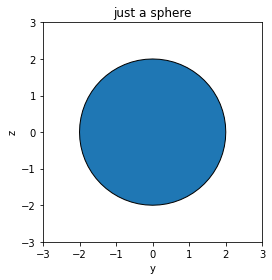

In [5]:
sphere = td.Structure(
    geometry=td.Sphere(center=(0,0,0), radius=2),
    medium=td.Medium(permittivity=3))

ax = sphere.plot(x=0)

ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_title('just a sphere')
plt.show()

Finally, since the geometry plotting us done using matplotlib Patches, you can supply optional keyword arguments to `.plot()` to change the display of the plot.

See [matplotlib's documentation on Patches](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html) for more information on arguments are accepted.

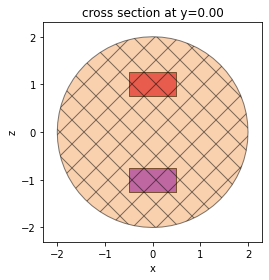

In [6]:
box1 = td.Box(center=(0.,1.,1), size=(1.,2.,.5))
box2 = td.Box(center=(0.,0.,-1), size=(1.,2.,.5))

ax = box1.plot(y=0, facecolor='crimson', edgecolor='black', alpha=1)
ax = box2.plot(y=0, ax=ax, facecolor='blueviolet', edgecolor='black', alpha=1)
ax = sphere.plot(y=0, ax=ax, facecolor='sandybrown', edgecolor='black', alpha=0.5, hatch='x')


### Simulations

We can plot all components contained in `td.Simulation` with the `Simulation.plot()` method.

Let's create a simulation with a source, monitor, and a bunch of randomly placed spheres made of 3 distinct `td.Medium`s.

In [7]:
from numpy.random import random

L = 5 # length of simulation on all sides

def rand():
    return L * (random() - 0.5)

# make random list of structures
structures = [
    td.Structure(
        geometry=td.Sphere(center=(rand(),rand(),rand()), radius=1),
        medium=td.Medium(permittivity=np.random.choice([2., 3., 4.])))
    for i in range(20)]

source = td.VolumeSource(
    center=(0, 0, -L/3),
    size=(L, L/2, 0),
    polarization='Ex',
    source_time = td.GaussianPulse(
        freq0=1.0,
        fwidth=.1,
    )
)

monitor = td.FieldMonitor(
    center=(-L/4,0,0),
    size=(L/2,L,0),
    freqs=[1]
)

# make simulation from structures
sim = td.Simulation(
    size=(L, L, L),
    grid_size=(.1, L/4, .1),
    pml_layers=(
        td.PML(num_layers=10),
        td.PML(num_layers=0),
        td.PML(num_layers=10)        
    ),
    structures=structures,
    sources={'src': source},
    monitors={'mon': monitor},
)

#### Plotting Materials

with `sim.plot` we can plot each distinct material, source, monitor, and PML.

Note, all structures with same `Medium` show up as the same color.

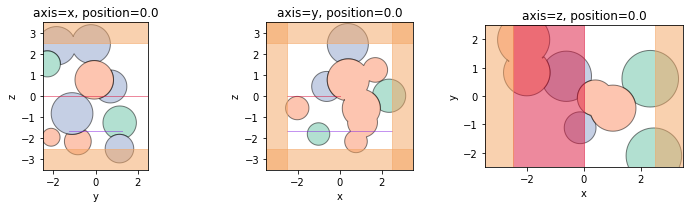

In [8]:
f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
for ax, axis in zip(axes, 'xyz'):
    
    ax = sim.plot(**{axis:0}, ax=ax, alpha=0.5)
    ax.set_title(f'axis={axis}, position=0.0')
plt.show()

We can even get fancy and plot the cross sections at different positions along the 3 axes.

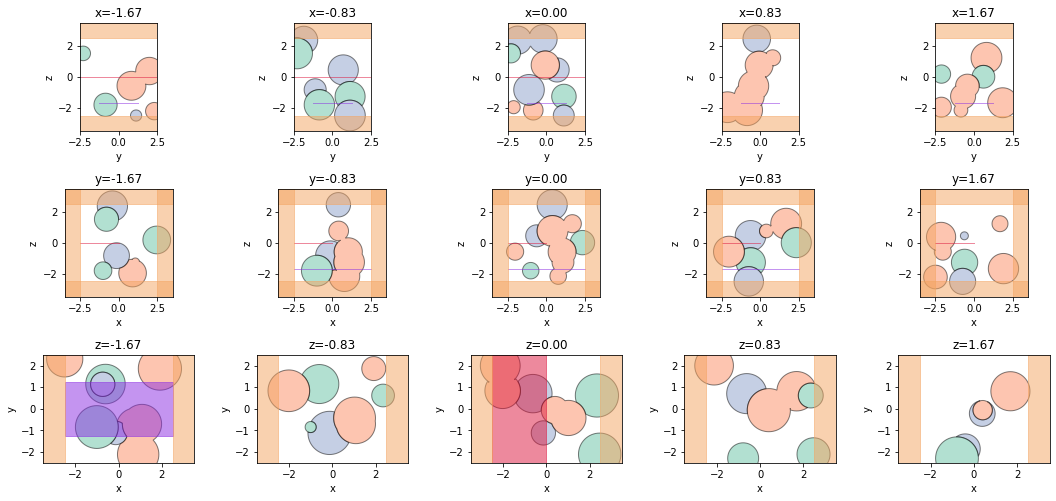

In [9]:
npos = 5
positions = np.linspace(-L/3, L/3, npos)
f, axes = plt.subplots(3, npos, tight_layout=True, figsize=(npos*3, 7))
for axes_range, axis in zip(axes, 'xyz'):
    for ax, pos in zip(axes_range, positions):
        ax = sim.plot(**{axis:pos}, ax=ax, alpha=0.5)
        ax.set_title(f'{axis}={pos:.2f}')
plt.show()

#### Plotting Permittivity

With `Simulation.plot_eps` we can plot the continuously varying permittivity distribution on the plane.

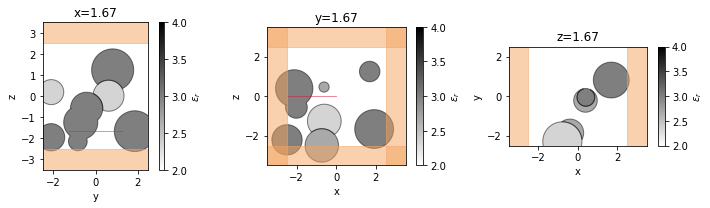

In [10]:
f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
for ax, axis in zip(axes, 'xyz'):
    ax = sim.plot_eps(**{axis:pos}, ax=ax, alpha=0.5)
    ax.set_title(f'{axis}={pos:.2f}')
plt.show()

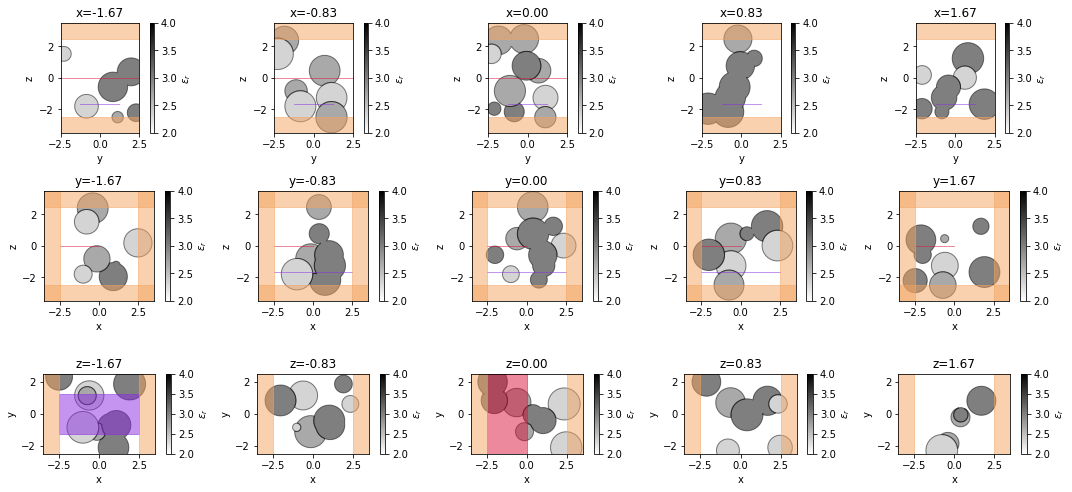

In [11]:
npos = 5
positions = np.linspace(-L/3, L/3, npos)
f, axes = plt.subplots(3, npos, tight_layout=True, figsize=(npos*3, 7))
for axes_range, axis in zip(axes, 'xyz'):
    for ax, pos in zip(axes_range, positions):
        ax = sim.plot_eps(**{axis:pos}, ax=ax, alpha=0.5)
        ax.set_title(f'{axis}={pos:.2f}')
plt.show()

#### Symmetries

Let's make a new simulation and add some symmetries.

In [12]:
# make simulation from structures
sim_symmetry = td.Simulation(
    size=(L, L, L),
    grid_size=(.1, L/4, .1),
    pml_layers=(
        td.PML(num_layers=10),
        None,
        td.PML(num_layers=10)        
    ),
    structures=structures,
    sources={'src': source},
    monitors={'mon': monitor},
    symmetry=(0,1,-1)
)

We see the symmetetries show up in the plot as dfferent colors to mask the regions where symmetry will be applied.

For example, the regions in green and blue will be assumed symmetric with respect to the lower left quadrant, even though the Simulation was not explicitly set up with that symmetry in the structures list.

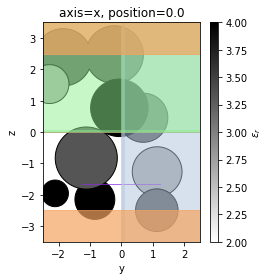

In [13]:
ax = sim_symmetry.plot_eps(x=0)
ax.set_title(f'axis=x, position=0.0')
plt.show()

## Plotting Other Quantities

### Structure + Medium

The `Structure.medium` refractive index values over frequency can be plotted with it's `.plot()` method as well.

[13:33:56] WARNING  frequency passed to `Medium.eps_model()`is outside of        ]8;id=75189;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/components/medium.py\medium.py]8;;\:53
                    `Medium.frequency_range` = (151926744799612.75,                          
                    7596337239980637.0)

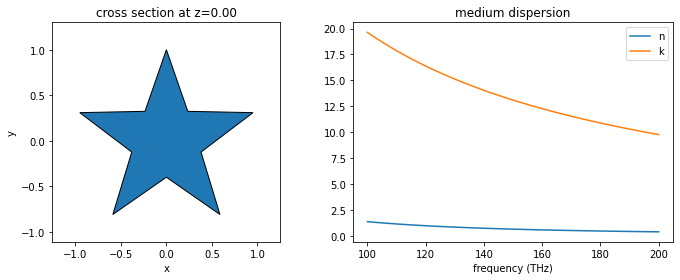

In [14]:
# import silver from material library
from tidy3d import material_library
Ag = material_library['Ag']['Rakic1998']

# make a star-shaped PolySlab
import numpy as np
r_in = 0.4
r_out = 1.0
inner_vertices = [(r_in * np.cos(2*np.pi*i/5 + np.pi/2 - np.pi/5), r_in * np.sin(2*np.pi*i/5 + np.pi/2 - np.pi/5)) for i in range(5)]
outer_vertices = [(r_out * np.cos(2*np.pi*i/5 + np.pi/2), r_out * np.sin(2*np.pi*i/5 + np.pi/2)) for i in range(5)]
star_vertices = []
for i in range(5):
    star_vertices.append(inner_vertices[i])
    star_vertices.append(outer_vertices[i])
poly_star = td.PolySlab(vertices=star_vertices, slab_bounds=(-1,1), axis=2)

# make a star structure with silver as medium
silver_star = td.Structure(
    geometry=poly_star,
    medium=Ag
)

# plot the structrue alongside the medium properties
freqs = np.linspace(1e14, 2e14, 101)
position = 0.0
axis=2

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
ax1 = silver_star.geometry.plot(z=0, edgecolor='black', ax=ax1)
ax2 = silver_star.medium.plot(freqs=freqs, ax=ax2)

## Source + Source Time

Similarly, the `Source.source_time` amplitude over time can be plotted with its `.plot()` method.

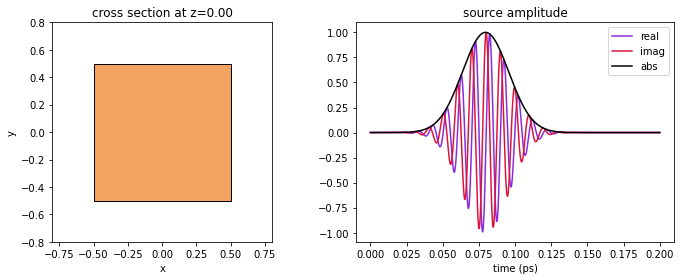

In [15]:
cube_source = td.VolumeSource(
    center=(0,0,0),
    size=(1,1,1),
    polarization='Ex',
    source_time=td.GaussianPulse(
        freq0=1e14,
        fwidth=1e13,
    )
)

times = np.linspace(0, .2e-12, 1001)
position = 0.0
axis=2

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
ax1 = cube_source.geometry.plot(z=0, facecolor='sandybrown', edgecolor='black', ax=ax1)
ax2 = cube_source.source_time.plot(times=times, ax=ax2)

## Monitor

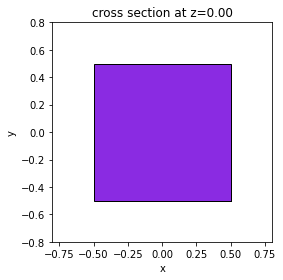

In [16]:
freq_mon = td.FieldMonitor(
    center=(0,0,0),
    size=(1,1,1),
    freqs=list(np.linspace(1e14, 2e14, 11)),
)

position = 0.0
axis=2

ax = freq_mon.geometry.plot(z=0, facecolor='blueviolet', edgecolor='black')

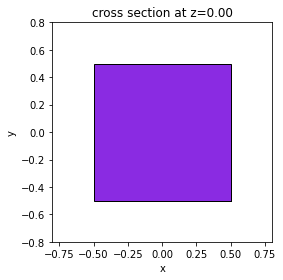

In [17]:
time_mon = td.FieldTimeMonitor(
    center=(0,0,0),
    size=(1,1,1),
    interval=10,
)

position = 0.0
axis=2

ax = time_mon.geometry.plot(z=0, facecolor='blueviolet', edgecolor='black')

## Interactive Plotting

With the `.visualize()` methods, we can produce interactive geometry plots where the position can be controlled with sliders.

### Geometry


In [18]:
c = td.Cylinder(center=(0,-0,0), radius=.5, length=2.0, axis=2)

# plot all three axes at once
# c.visualize(axis=0) + c.visualize(axis=1) + c.visualize(axis=2)

In [19]:
# poly_star.visualize(axis=0) + poly_star.visualize(axis=1) + poly_star.visualize(axis=2)